In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai.conv_learner import *

In [3]:
input_size   = 784
encoding_dim = 32
bs = 16
tfm0 = torchvision.transforms.ToTensor()  # convert [0,255] -> [0.0,1.0]

In [4]:
train_dataset = torchvision.datasets.MNIST('data/MNIST/',train=True, transform=tfm0)
test_dataset  = torchvision.datasets.MNIST('data/MNIST/',train=False,transform=tfm0)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset,  batch_size=bs)

In [5]:
# create copies of dataloaders for ModelData
train_loadermd = copy.deepcopy(train_loader)
test_loadermd  = copy.deepcopy(test_loader)

# set y to be x and convert [0,255] int to [0.0,1.0] float. (dl doesnt trsfm `y` by default)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_data.type(torch.FloatTensor)/255
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_data.type(torch.FloatTensor)/255

# add channel dimension for compatibility. (bs,h,w) –> (bs,ch,h,w)
train_loadermd.dataset.train_labels = train_loadermd.dataset.train_labels.reshape((len(train_loadermd.dataset),1,28,28))
test_loadermd.dataset.test_labels   = test_loadermd.dataset.test_labels.reshape((len(test_loadermd.dataset),1,28,28))

In [6]:
md = ModelData('data/MNIST', train_loadermd, test_loadermd)

In [7]:
def compare_batch(x, z, bs=16, figsize=(16,2)):
    bs = min(len(x), bs) # digits to display
    fig = plt.figure(figsize=figsize)
    for i in range(bs):
        # display original
        ax = plt.subplot(2, bs, i+1); ax.imshow(x[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
        
        # display reconstruction
        ax = plt.subplot(2, bs, i+1+bs); ax.imshow(z[i].reshape(28,28))
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

In [8]:
class VEncoder(nn.Module):
    def __init__(self, input_size, interm_size, latent_size):
        #TODO
    
    def forward(self, x):
        #TODO

class VSampler(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        #TODO

class VDecoder(nn.Module):
    def __init__(self, output_size, interm_size, latent_size):
        #TODO
    
    def forward(self, x):
       #TODO
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=32, latent_shape=16):
        super().__init__()
        #todo
    
    def forward(self, x):
        #TODO

def vae_loss(z, xtra, raw_loss):
    #TODO

In [8]:
class VEncoder(nn.Module):
    """Returns intermediate encodings, mean, and log(stdev) tensors."""
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(input_size,  interm_size)
        self.mean_layer   = nn.Linear(interm_size, latent_size)
        self.stdv_layer   = nn.Linear(interm_size, latent_size)
    
    def forward(self, x):
        x     = F.relu(self.intermediate(x))
        μ     = F.relu(self.mean_layer(x)) # Mean vector
        log_σ = F.relu(self.stdv_layer(x)) # Stdv vector
        return x, μ, log_σ

class VSampler(nn.Module):
    """
        Multiplies standard deviation vector by a ~N(0,1) Gaussian distribution.
        Returns mean + new stdev.
        For theory see: https://youtu.be/uaaqyVS9-rM?t=19m42s
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        μ, log_σ = x 
        eps = torch.randn(μ.shape) # should I set `requires_grad=True`?
        return μ + torch.exp(log_σ)*eps

class VDecoder(nn.Module):
    """Decodes sampled """
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.intermediate = nn.Linear(latent_size, interm_size)
        self.out          = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.intermediate(x))
        x = F.sigmoid(self.out(x))
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=32, latent_shape=16):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten
        enc_x, *μ_log_σ = self.encoder(x) # encode
        x = self.sampler(μ_log_σ)         # sample
        x = self.decoder(x)               # decode
        x = x.reshape(x.size(0),1,28,28)  # 'unflatten' -- could I use x.view(..)?
        return x, μ_log_σ, enc_x
    
def vae_loss(z, xtra, raw_loss):
    μ_log_σ, _ = xtra
    μ, log_σ   = μ_log_σ
    
    σ = torch.exp(log_σ)
    
    reconstruction_loss = raw_loss
    kl_divergence_loss  = -0.5 * torch.sum(1. + torch.exp(torch.log(σ**2)) + μ**2 - σ**2)
    return reconstruction_loss + kl_divergence_loss

In [67]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21= nn.Linear(400, 20)
        self.fc22= nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        
        else:
            return mu
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch, log_interval=100):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, enc = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    

In [66]:
train(1)

## fastai

In [54]:
interm_shape = 512
latent_shape = 2

learn = Learner.from_model_data(
    VariationalAutoencoder(interm_shape=interm_shape, latent_shape=latent_shape), md)

learn.opt_fn = torch.optim.RMSprop
learn.crit   = F.binary_cross_entropy
learn.reg_fn = vae_loss

 22%|██▏       | 841/3750 [00:15<00:54, 53.35it/s, loss=1.16] 

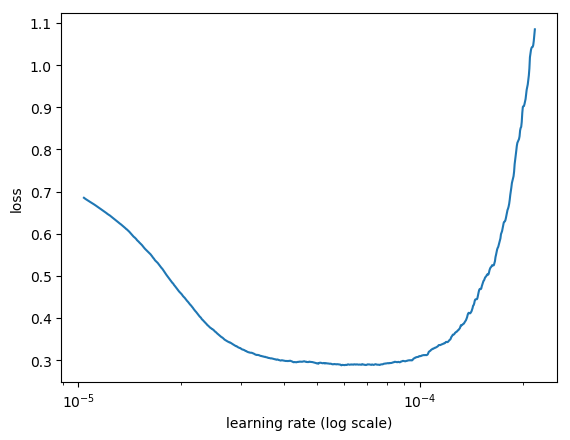

 22%|██▏       | 841/3750 [00:33<01:54, 25.44it/s, loss=1.16]

In [55]:
learn.lr_find()
learn.sched.plot()

In [56]:
%time learn.fit(2e-5, 5)

epoch      trn_loss   val_loss                                 
    0      0.291528   0.293099  
    1      0.36097    0.353388                                 
    2      0.595576   0.535724                                 
    3      1.153845   1.013346                                 
    4      3.125476   3.167777                                
CPU times: user 18min 50s, sys: 1min 30s, total: 20min 20s
Wall time: 7min 34s


[3.1677772563934328]

In [59]:
x,y = next(iter(test_loader))

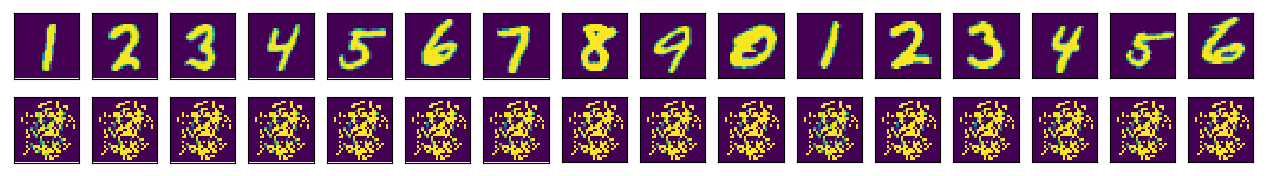

In [62]:
z = learn.model(x)
compare_batch(x,z[0].detach())

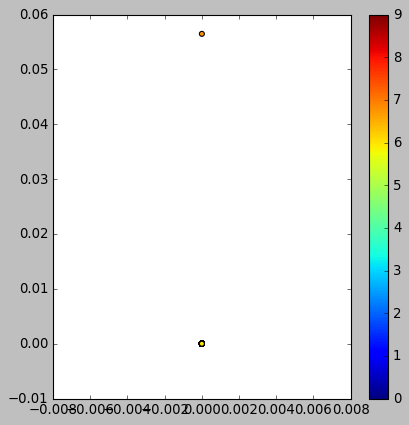

In [65]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μlogvar, enc_x = learn.model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar(); plt.style.use('default')

### pytorch

In [36]:
x,y = next(iter(test_loader))

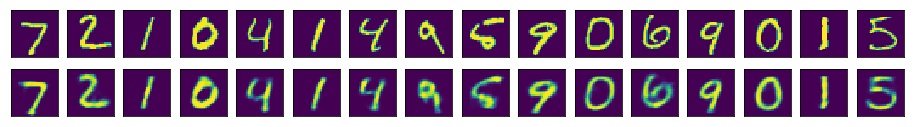

In [37]:
z = model(x)
compare_batch(x,z[0].detach())

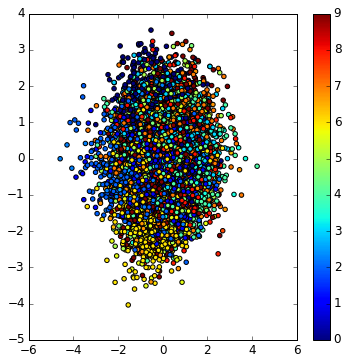

In [38]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

In [40]:
for i in range(2,4): train(i, log_interval=400)

Train Epoch: 2 [0/60000 (0%)]	Loss: 114.496765
Train Epoch: 2 [6400/60000 (11%)]	Loss: 116.338478
Train Epoch: 2 [12800/60000 (21%)]	Loss: 108.551849
Train Epoch: 2 [19200/60000 (32%)]	Loss: 112.641205
Train Epoch: 2 [25600/60000 (43%)]	Loss: 98.701385
Train Epoch: 2 [32000/60000 (53%)]	Loss: 105.388115
Train Epoch: 2 [38400/60000 (64%)]	Loss: 104.641022
Train Epoch: 2 [44800/60000 (75%)]	Loss: 117.878220
Train Epoch: 2 [51200/60000 (85%)]	Loss: 113.666855
Train Epoch: 2 [57600/60000 (96%)]	Loss: 114.570114
====> Epoch: 2 Average loss: 111.9494
Train Epoch: 3 [0/60000 (0%)]	Loss: 109.839569
Train Epoch: 3 [6400/60000 (11%)]	Loss: 102.008751
Train Epoch: 3 [12800/60000 (21%)]	Loss: 97.235146
Train Epoch: 3 [19200/60000 (32%)]	Loss: 111.783752
Train Epoch: 3 [25600/60000 (43%)]	Loss: 111.491615
Train Epoch: 3 [32000/60000 (53%)]	Loss: 106.772949
Train Epoch: 3 [38400/60000 (64%)]	Loss: 113.803787
Train Epoch: 3 [44800/60000 (75%)]	Loss: 107.029579
Train Epoch: 3 [51200/60000 (85%)]	Loss:

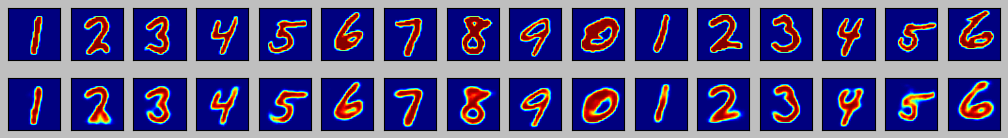

In [41]:
z = model(x)
compare_batch(x,z[0].detach())

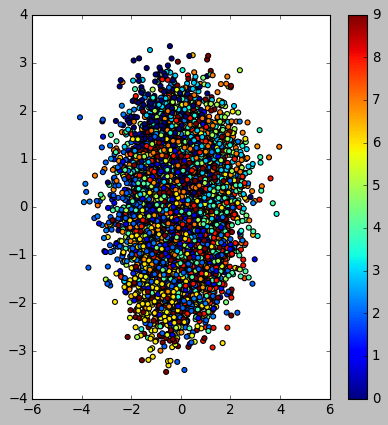

In [42]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

In [43]:
for i in range(4,9): train(i, log_interval=800)

Train Epoch: 4 [0/60000 (0%)]	Loss: 119.076149
Train Epoch: 4 [12800/60000 (21%)]	Loss: 102.149292
Train Epoch: 4 [25600/60000 (43%)]	Loss: 107.454697
Train Epoch: 4 [38400/60000 (64%)]	Loss: 109.867874
Train Epoch: 4 [51200/60000 (85%)]	Loss: 113.596527
====> Epoch: 4 Average loss: 108.4154
Train Epoch: 5 [0/60000 (0%)]	Loss: 101.318573
Train Epoch: 5 [12800/60000 (21%)]	Loss: 106.810196
Train Epoch: 5 [25600/60000 (43%)]	Loss: 113.243889
Train Epoch: 5 [38400/60000 (64%)]	Loss: 112.109657
Train Epoch: 5 [51200/60000 (85%)]	Loss: 111.180504
====> Epoch: 5 Average loss: 107.7043
Train Epoch: 6 [0/60000 (0%)]	Loss: 115.137970
Train Epoch: 6 [12800/60000 (21%)]	Loss: 117.728516
Train Epoch: 6 [25600/60000 (43%)]	Loss: 111.289085
Train Epoch: 6 [38400/60000 (64%)]	Loss: 114.311394
Train Epoch: 6 [51200/60000 (85%)]	Loss: 109.223373
====> Epoch: 6 Average loss: 107.1152
Train Epoch: 7 [0/60000 (0%)]	Loss: 100.234497
Train Epoch: 7 [12800/60000 (21%)]	Loss: 104.402672
Train Epoch: 7 [25600/

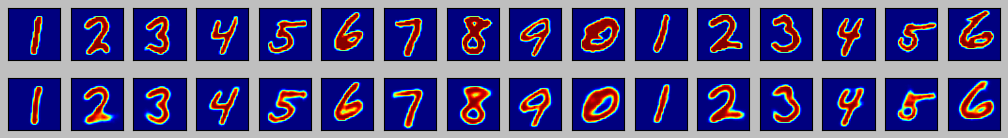

In [45]:
z = model(x)
compare_batch(x,z[0].detach())

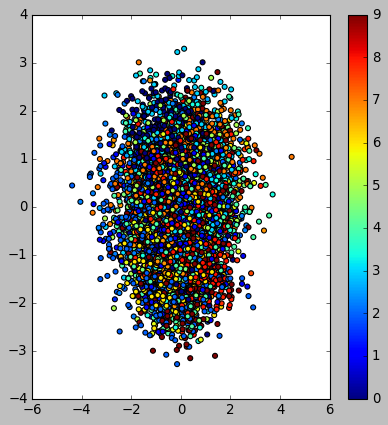

In [46]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

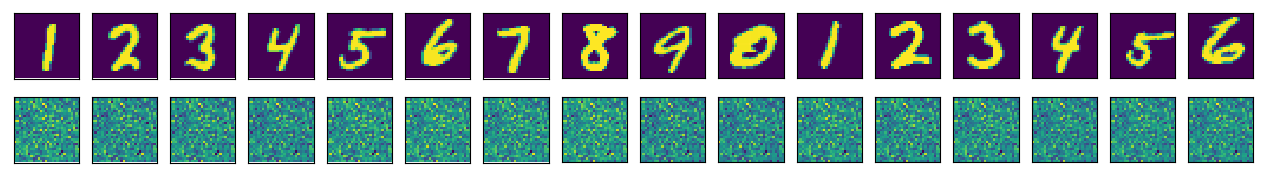

In [68]:
model.eval()
z = model(x)
compare_batch(x,z[0].detach())

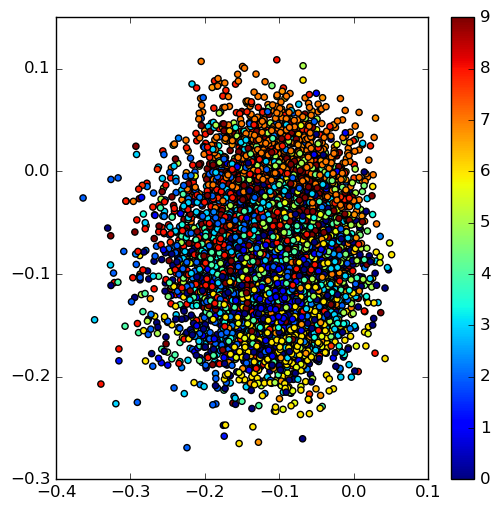

In [69]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

In [71]:
for i in range(9, 16): train(i, log_interval=600)

Train Epoch: 9 [0/60000 (0%)]	Loss: 135.101318
Train Epoch: 9 [9600/60000 (16%)]	Loss: 126.360649
Train Epoch: 9 [19200/60000 (32%)]	Loss: 139.893341
Train Epoch: 9 [28800/60000 (48%)]	Loss: 118.382202
Train Epoch: 9 [38400/60000 (64%)]	Loss: 121.938026
Train Epoch: 9 [48000/60000 (80%)]	Loss: 110.222198
Train Epoch: 9 [57600/60000 (96%)]	Loss: 98.864090
====> Epoch: 9 Average loss: 119.2132
Train Epoch: 10 [0/60000 (0%)]	Loss: 110.889046
Train Epoch: 10 [9600/60000 (16%)]	Loss: 106.543854
Train Epoch: 10 [19200/60000 (32%)]	Loss: 98.555618
Train Epoch: 10 [28800/60000 (48%)]	Loss: 108.272552
Train Epoch: 10 [38400/60000 (64%)]	Loss: 107.302368
Train Epoch: 10 [48000/60000 (80%)]	Loss: 109.549362
Train Epoch: 10 [57600/60000 (96%)]	Loss: 113.537971
====> Epoch: 10 Average loss: 111.4274
Train Epoch: 11 [0/60000 (0%)]	Loss: 104.876556
Train Epoch: 11 [9600/60000 (16%)]	Loss: 105.003159
Train Epoch: 11 [19200/60000 (32%)]	Loss: 100.055115
Train Epoch: 11 [28800/60000 (48%)]	Loss: 112.358

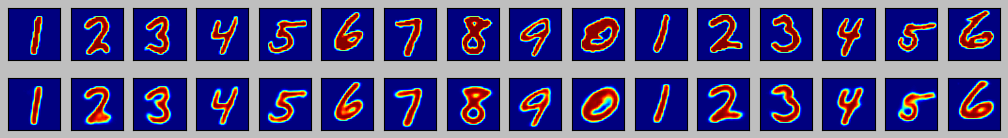

In [72]:
model.eval()
z = model(x)
compare_batch(x,z[0].detach())

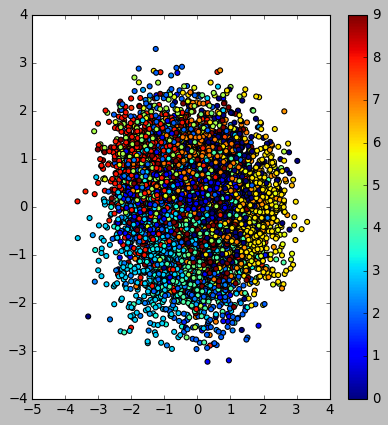

In [73]:
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar();

In [74]:
for i in range(16, 26): train(i, log_interval=1200)

Train Epoch: 16 [0/60000 (0%)]	Loss: 99.604576
Train Epoch: 16 [19200/60000 (32%)]	Loss: 101.857910
Train Epoch: 16 [38400/60000 (64%)]	Loss: 111.971458
Train Epoch: 16 [57600/60000 (96%)]	Loss: 110.456482
====> Epoch: 16 Average loss: 106.2854
Train Epoch: 17 [0/60000 (0%)]	Loss: 94.061401
Train Epoch: 17 [19200/60000 (32%)]	Loss: 103.381485
Train Epoch: 17 [38400/60000 (64%)]	Loss: 112.233429
Train Epoch: 17 [57600/60000 (96%)]	Loss: 106.485519
====> Epoch: 17 Average loss: 105.9140
Train Epoch: 18 [0/60000 (0%)]	Loss: 108.326279
Train Epoch: 18 [19200/60000 (32%)]	Loss: 110.450745
Train Epoch: 18 [38400/60000 (64%)]	Loss: 99.025009
Train Epoch: 18 [57600/60000 (96%)]	Loss: 98.973427
====> Epoch: 18 Average loss: 105.6636
Train Epoch: 19 [0/60000 (0%)]	Loss: 104.478188
Train Epoch: 19 [19200/60000 (32%)]	Loss: 114.903824
Train Epoch: 19 [38400/60000 (64%)]	Loss: 107.055138
Train Epoch: 19 [57600/60000 (96%)]	Loss: 108.084312
====> Epoch: 19 Average loss: 105.3881
Train Epoch: 20 [0/6

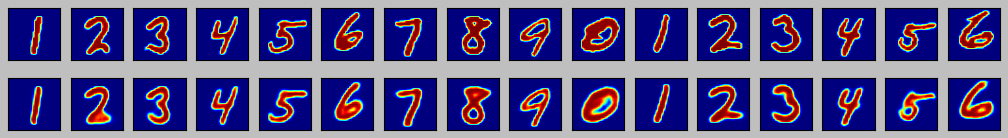

In [75]:
model.eval()
z = model(x)
compare_batch(x,z[0].detach())

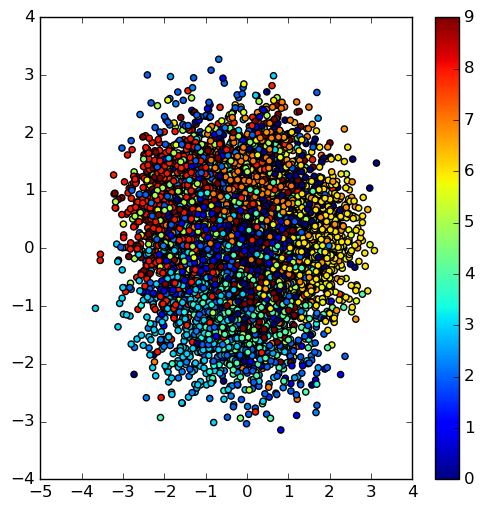

In [80]:
model.eval()
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
plt.colorbar(); plt.style.use('default');

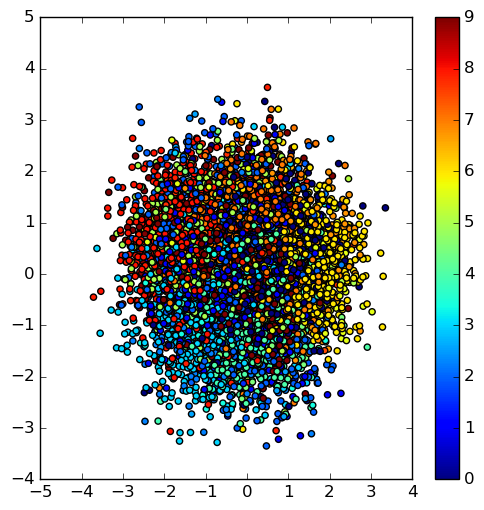

In [79]:
model.train()
plt.figure(figsize=(6,6)); plt.style.use('classic');

for x,y in iter(test_loader):
    z, μ, logvar, enc_x = model(x)
    z, μ, logv = model(x)
    
    plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y, alpha=0.1); 
plt.colorbar(); plt.style.use('default');

## new fastai

Here it is:

In [ ]:
def reparameterize(self, μ, logv):
    if self.training:
        σ = torch.exp(0.5*logv)
        ε = torch.randn_like(σ)
        return ε.mul(σ).add_(μ)
    else:
        return μ
    
def loss_function(recon_x, x, μ, logv):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return BCE + KLD

In [105]:
tensor = torch.randn(5,5); tensor

tensor.add_()

tensor([[ 0.3593,  0.9288,  1.3615, -1.4989, -0.0775],
        [ 0.2959,  0.1925, -0.9268,  1.1178, -0.9779],
        [ 1.0746, -0.1723,  0.6789, -0.8783,  1.3046],
        [-0.9525, -1.2053, -0.8948, -1.4165,  1.3921],
        [-0.0010, -0.0899,  0.6152, -0.0413,  2.0693]])

In [143]:
def space_plot(model):
    model.eval()
    plt.figure(figsize=(6,6)); plt.style.use('classic');

    for x,y in iter(test_loader):
        z, μ, logvar, enc_x = model(x)

        plt.scatter(enc_x.detach()[:,0], enc_x.detach()[:,1], c=y); 
    plt.colorbar(); plt.style.use('default');

In [155]:
class VEncoder(nn.Module):
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.fc0  = nn.Linear(input_size, interm_size)
        self.fc10 = nn.Linear(interm_size, latent_size)
        self.fc11 = nn.Linear(interm_size, latent_size)
    
    def forward(self, x):
        h1   = F.relu(self.fc0(x))
        μ    = F.relu(self.fc10(h1))
        logv = F.relu(self.fc11(h1))
        return μ, logv

class VSampler(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, μ, logv):
        σ = torch.exp(0.5*logv)
        ε = torch.randn_like(σ)
        return ε.mul(σ).add_(μ)

class VDecoder(nn.Module):
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.fc2 = nn.Linear(latent_size, interm_size)
        self.fc3 = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        h3 = F.relu(self.fc2(x))
        z  = F.sigmoid(self.fc3(h3))
        return z
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=512, latent_shape=2):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        μ,logv = self.encoder(x)
        enc = self.sampler(μ, logv)
        z = self.decoder(enc)
        z = z.view(z.size(0), 1, 28, 28)
        return z, μ, logv, enc

def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return KLD + BCE

In [156]:
learn = Learner.from_model_data(VariationalAutoencoder(), md)
learn.crit   = F.binary_cross_entropy
learn.opt_fn = torch.optim.Adam
learn.reg_fn = vae_loss

 95%|█████████▍| 3556/3750 [02:39<00:08, 22.36it/s, loss=1.06] 

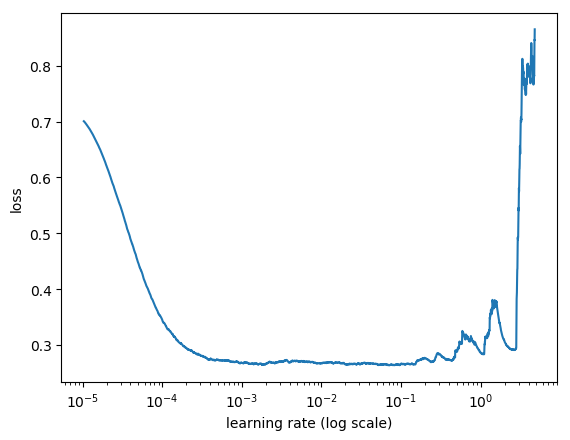

 95%|█████████▍| 3556/3750 [02:50<00:09, 20.91it/s, loss=1.06]

In [157]:
learn.lr_find()
learn.sched.plot()

In [158]:
%time learn.fit(1e-4, 2)

epoch      trn_loss   val_loss                                 
    0      0.262115   0.263481  
    1      0.263347   0.263008                                 
CPU times: user 9min 56s, sys: 42 s, total: 10min 38s
Wall time: 4min 13s


[0.2630080086231232]

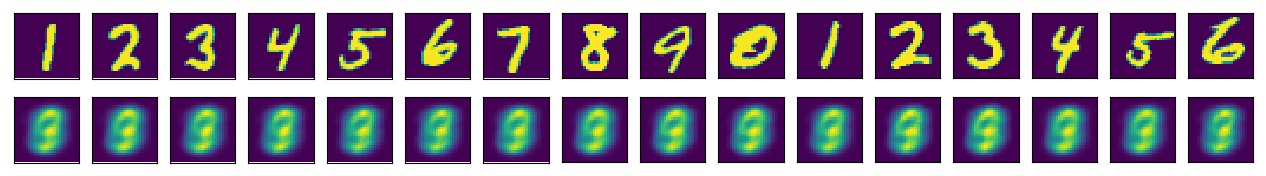

In [159]:
z = learn.model(x)
compare_batch(x,z[0].detach())

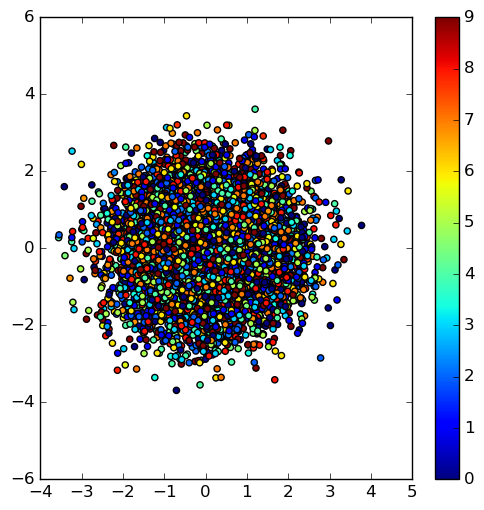

In [160]:
space_plot(learn.model)

Can this train just in pytorch?

In [170]:
def loss_function(recon_x, mu, logvar, x):
    BCE = F.binary_cross_entropy(recon_x.view(recon_x.size(0),-1), x.view(x.size(0), -1), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch, log_interval=100):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, enc = model(data)
        loss = loss_function(recon_batch, mu, logvar, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
for i in range(2): train(i+1, log_interval=400)

Train Epoch: 1 [0/60000 (0%)]	Loss: 556.586975
Train Epoch: 1 [6400/60000 (11%)]	Loss: 197.652359
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.272598
Train Epoch: 1 [19200/60000 (32%)]	Loss: 191.010284
Train Epoch: 1 [25600/60000 (43%)]	Loss: 186.229980
Train Epoch: 1 [32000/60000 (53%)]	Loss: 194.730453
Train Epoch: 1 [38400/60000 (64%)]	Loss: 192.816345
Train Epoch: 1 [44800/60000 (75%)]	Loss: 169.987778
Train Epoch: 1 [51200/60000 (85%)]	Loss: 190.958588
Train Epoch: 1 [57600/60000 (96%)]	Loss: 198.626343
====> Epoch: 1 Average loss: 192.8486
Train Epoch: 2 [0/60000 (0%)]	Loss: 177.357559
Train Epoch: 2 [6400/60000 (11%)]	Loss: 181.279556
Train Epoch: 2 [12800/60000 (21%)]	Loss: 189.552063
Train Epoch: 2 [19200/60000 (32%)]	Loss: 196.046036
Train Epoch: 2 [25600/60000 (43%)]	Loss: 164.301559
Train Epoch: 2 [32000/60000 (53%)]	Loss: 202.749283
Train Epoch: 2 [38400/60000 (64%)]	Loss: 212.898865
Train Epoch: 2 [44800/60000 (75%)]	Loss: 199.810684
Train Epoch: 2 [51200/60000 (85%)]	Los

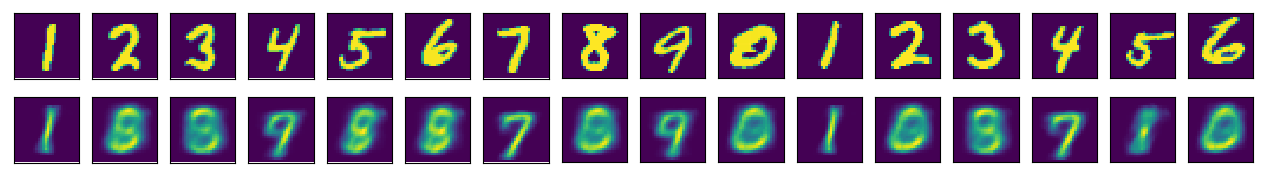

In [171]:
z = model(x)
compare_batch(x,z[0].detach())

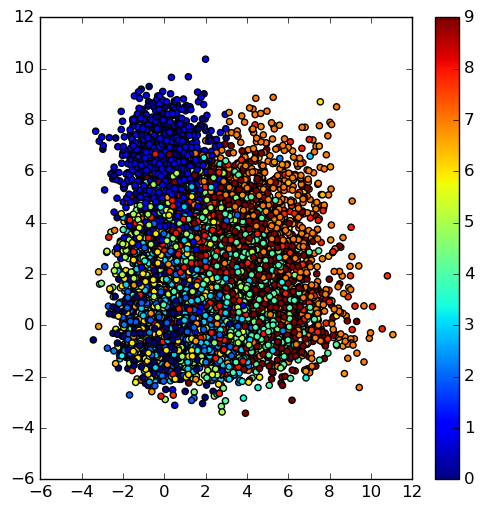

In [172]:
space_plot(model)

It's starting to train...

That means my architecture is fine.

The issue is the training mechanics. I have to see what's going on in fastai's training process that's causing problems.

In [173]:
x,y = next(iter(learn.data.val_dl))

In [174]:
y.shape

torch.Size([16, 1, 28, 28])

Is the problem that Y is not flattened when compared to X in BCE?

In [180]:
model(x)[0].shape, x.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16, 1, 28, 28]))

In [198]:
def loss_function(recon_x, mu, logvar, x):
    BCE = F.binary_cross_entropy(recon_x.view(recon_x.size(0),-1), x.view(x.size(0), -1), size_average=False)
#     BCE = F.binary_cross_entropy(
#         recon_x.view(recon_x.size(0),1,28,28), x.view(x.size(0),1,28,28), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
# def vae_loss(z, xtra, raw_loss):
#     μ, logv, *_ = xtra
#     BCE = raw_loss
#     KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
#     return KLD + BCE

In [182]:
model  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in range(1,3): train(i, log_interval=400)

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.483032
Train Epoch: 1 [6400/60000 (11%)]	Loss: 195.102448
Train Epoch: 1 [12800/60000 (21%)]	Loss: 191.502090
Train Epoch: 1 [19200/60000 (32%)]	Loss: 225.140503
Train Epoch: 1 [25600/60000 (43%)]	Loss: 225.465698
Train Epoch: 1 [32000/60000 (53%)]	Loss: 213.890625
Train Epoch: 1 [38400/60000 (64%)]	Loss: 202.107864
Train Epoch: 1 [44800/60000 (75%)]	Loss: 210.551651
Train Epoch: 1 [51200/60000 (85%)]	Loss: 194.623108
Train Epoch: 1 [57600/60000 (96%)]	Loss: 204.177979
====> Epoch: 1 Average loss: 208.5231
Train Epoch: 2 [0/60000 (0%)]	Loss: 219.092087
Train Epoch: 2 [6400/60000 (11%)]	Loss: 203.492554
Train Epoch: 2 [12800/60000 (21%)]	Loss: 198.818848
Train Epoch: 2 [19200/60000 (32%)]	Loss: 178.809357
Train Epoch: 2 [25600/60000 (43%)]	Loss: 221.985855
Train Epoch: 2 [32000/60000 (53%)]	Loss: 198.865799
Train Epoch: 2 [38400/60000 (64%)]	Loss: 197.747742
Train Epoch: 2 [44800/60000 (75%)]	Loss: 218.260849
Train Epoch: 2 [51200/60000 (85%)]	Los

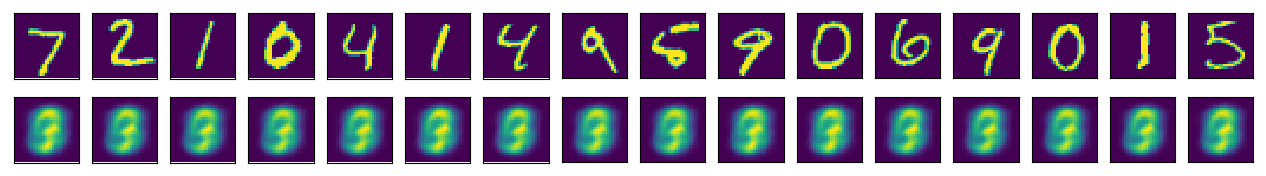

In [183]:
z = model(x)
compare_batch(x,z[0].detach())

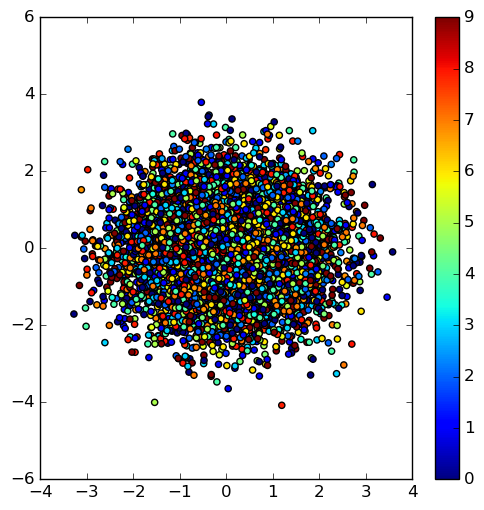

In [184]:
space_plot(model)

In [192]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=False)

In [193]:
learn = Learner.from_model_data(VariationalAutoencoder(), md)
learn.crit   = flat_bce
learn.opt_fn = torch.optim.Adam
learn.reg_fn = vae_loss

epoch      trn_loss   val_loss                                    
    0      4652.161257 4782.063599


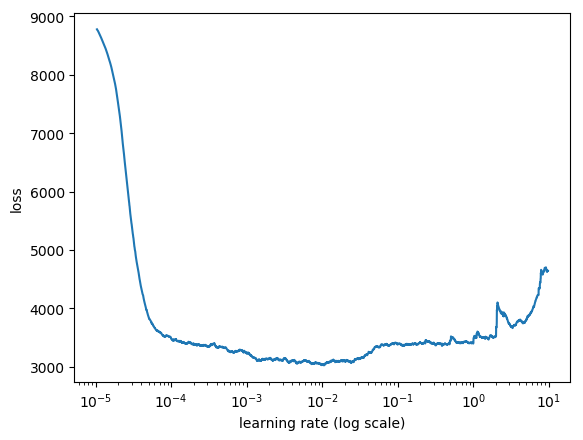

In [194]:
learn.lr_find()
learn.sched.plot()

In [195]:
%time learn.fit(1e-3, 2)

epoch      trn_loss   val_loss                                    
    0      3327.019184 3303.191396
    1      3322.707768 3299.35344                                 
CPU times: user 9min 52s, sys: 40.8 s, total: 10min 33s
Wall time: 3min 53s


[3299.353440234375]

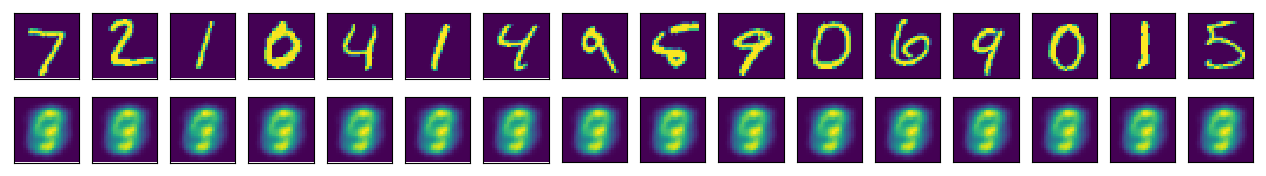

In [196]:
z = learn.model(x)
compare_batch(x,z[0].detach())

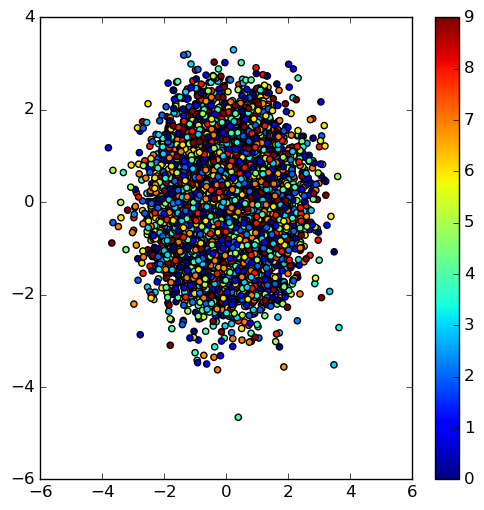

In [197]:
space_plot(learn.model)

In [199]:
model  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in range(1,3): train(i, log_interval=800)

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.979858
Train Epoch: 1 [12800/60000 (21%)]	Loss: 195.986893
Train Epoch: 1 [25600/60000 (43%)]	Loss: 218.515411
Train Epoch: 1 [38400/60000 (64%)]	Loss: 203.368835
Train Epoch: 1 [51200/60000 (85%)]	Loss: 211.446701
====> Epoch: 1 Average loss: 204.1530
Train Epoch: 2 [0/60000 (0%)]	Loss: 185.867157
Train Epoch: 2 [12800/60000 (21%)]	Loss: 192.000244
Train Epoch: 2 [25600/60000 (43%)]	Loss: 186.274536
Train Epoch: 2 [38400/60000 (64%)]	Loss: 201.097900
Train Epoch: 2 [51200/60000 (85%)]	Loss: 186.672546
====> Epoch: 2 Average loss: 201.2597


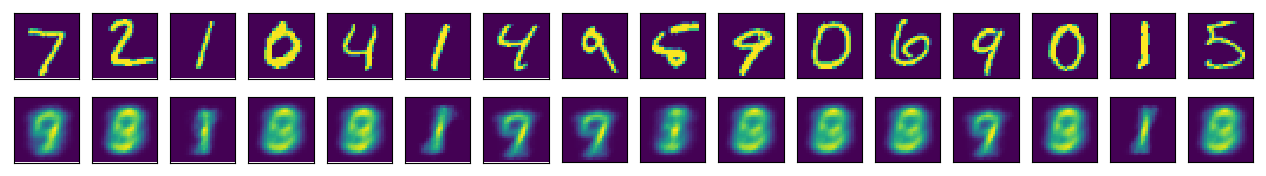

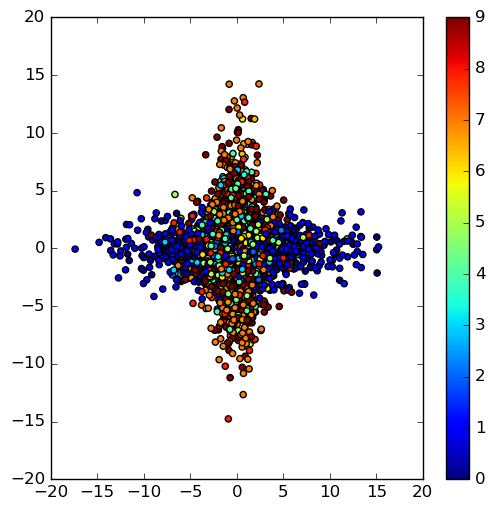

In [202]:
model.eval(); z = model(x)
compare_batch(x,z[0].detach())
space_plot(model)

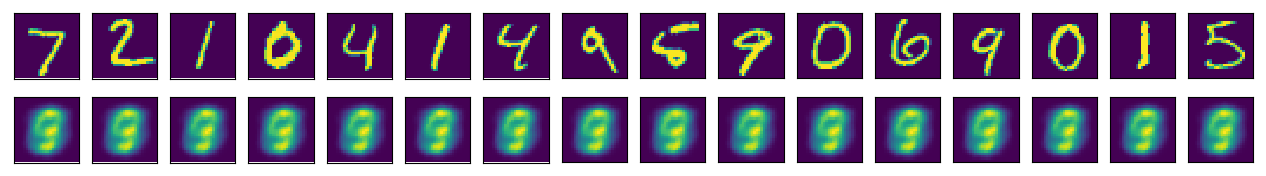

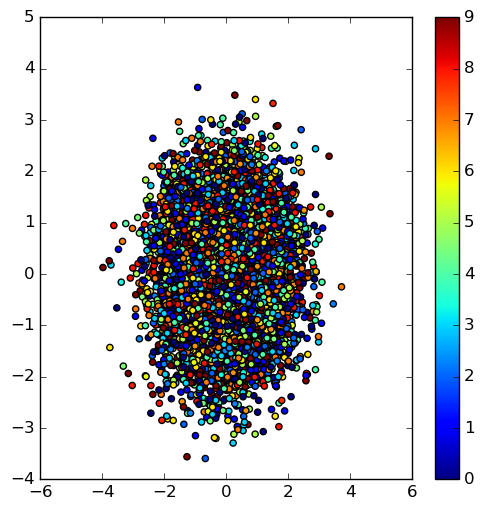

In [200]:
z = learn.model(x)
compare_batch(x,z[0].detach())
space_plot(learn.model)

I need to see what the tensor shapes going in and out of the loss functions are. There has to be a reason why the fastai Learner isn't training.

### 1st question: do the models do the same thing if I remove KLD loss?

In [205]:
def vae_loss(z, xtra, raw_loss):
#     pdb.set_trace()
    μ, logv, *_ = xtra
    BCE = raw_loss
#     KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
#     return KLD + BCE
    return BCE

In [206]:
def loss_function(recon_x, mu, logvar, x):
#     pdb.set_trace()
    BCE = F.binary_cross_entropy(recon_x.view(recon_x.size(0),-1), x.view(x.size(0), -1), size_average=False)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD
    return BCE
model  = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in range(1,3): train(i, log_interval=800)

Train Epoch: 1 [0/60000 (0%)]	Loss: 553.247864
Train Epoch: 1 [12800/60000 (21%)]	Loss: 218.755981
Train Epoch: 1 [25600/60000 (43%)]	Loss: 195.312302
Train Epoch: 1 [38400/60000 (64%)]	Loss: 229.852554
Train Epoch: 1 [51200/60000 (85%)]	Loss: 186.760925
====> Epoch: 1 Average loss: 208.5323
Train Epoch: 2 [0/60000 (0%)]	Loss: 203.506256
Train Epoch: 2 [12800/60000 (21%)]	Loss: 197.768875
Train Epoch: 2 [25600/60000 (43%)]	Loss: 204.215118
Train Epoch: 2 [38400/60000 (64%)]	Loss: 194.440842
Train Epoch: 2 [51200/60000 (85%)]	Loss: 227.417358
====> Epoch: 2 Average loss: 206.6145


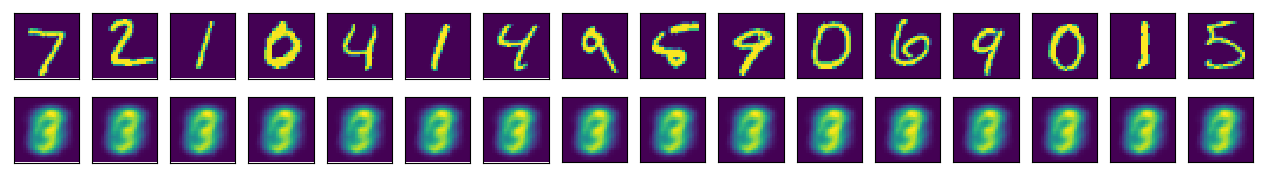

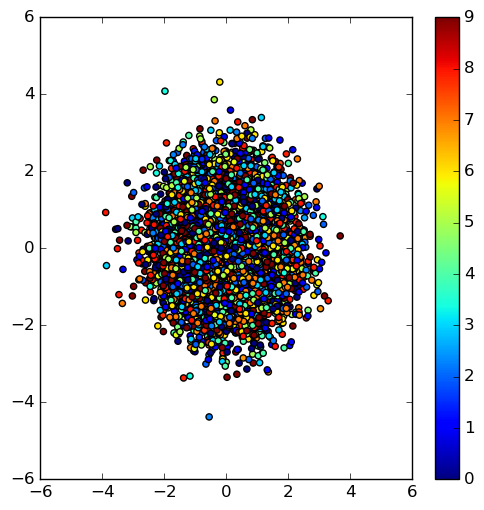

In [207]:
z = model(x)
compare_batch(x,z[0].detach())
space_plot(model)

In [208]:
learn = Learner.from_model_data(VariationalAutoencoder(), md)
learn.crit   = flat_bce
learn.opt_fn = torch.optim.Adam
learn.reg_fn = vae_loss

learn.fit(1e-3, 3)

epoch      trn_loss   val_loss                                    
    0      2820.398689 2837.586821
    1      2779.828228 2735.427973                                
    2      2714.47917 2695.510355                                 


[2695.51035546875]

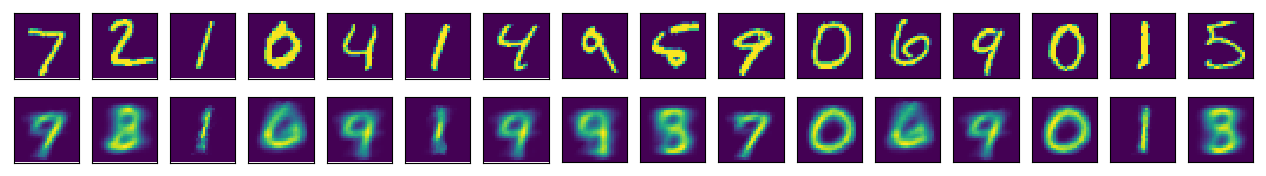

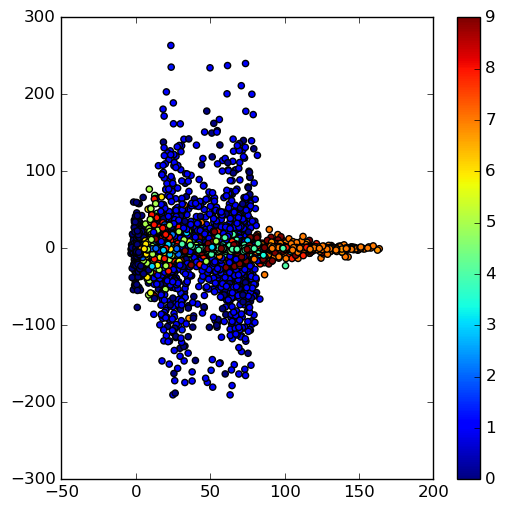

In [211]:
x,y = next(iter(learn.data.val_dl))
z = learn.model(x)
compare_batch(x,z[0].detach())
space_plot(learn.model)

In [9]:
class VEncoder(nn.Module):
    def __init__(self, input_size, interm_size, latent_size):
        super().__init__()
        self.fc0  = nn.Linear(input_size, interm_size)
        self.fc10 = nn.Linear(interm_size, latent_size)
        self.fc11 = nn.Linear(interm_size, latent_size)
    
    def forward(self, x):
        h1   = F.relu(self.fc0(x))
        μ    = F.relu(self.fc10(h1))
        logv = F.relu(self.fc11(h1))
        return μ, logv

class VSampler(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, μ, logv):
        if self.training:
            σ = torch.exp(0.5*logv)
            ε = torch.randn_like(σ)
            return ε.mul(σ).add_(μ)
        else:
            return μ

class VDecoder(nn.Module):
    def __init__(self, output_size, interm_size, latent_size):
        super().__init__()
        self.fc2 = nn.Linear(latent_size, interm_size)
        self.fc3 = nn.Linear(interm_size, output_size)
    
    def forward(self, x):
        h3 = F.relu(self.fc2(x))
        z  = F.sigmoid(self.fc3(h3))
        return z
        
class VariationalAutoencoder(nn.Module):
    def __init__(self, orign_shape=784, interm_shape=512, latent_shape=2):
        super().__init__()
        self.encoder = VEncoder(orign_shape, interm_shape, latent_shape)
        self.sampler = VSampler()
        self.decoder = VDecoder(orign_shape, interm_shape, latent_shape)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        μ,logv = self.encoder(x)
        enc = self.sampler(μ, logv)
        z = self.decoder(enc)
        z = z.view(z.size(0), 1, 28, 28)
        return z, μ, logv, enc

def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return KLD + BCE

In [10]:
def model_plots(model, dataloader=learn.data.val_dl):
    x,y = next(iter(dataloader))
    z = model(x)
    if len(z) > 1: print([zi.shape for zi in z]);
    compare_batch(x,z[0].detach())
    space_plot(model)

NameError: name 'learn' is not defined

In [14]:
def learner_test(eps=3, crit=flat_bce):
    learn = Learner.from_model_data(VariationalAutoencoder(), md)
    learn.crit   = crit
    learn.opt_fn = torch.optim.Adam
    learn.reg_fn = vae_loss
    learn.fit(1e-3, eps)
    return learn

def pytorch_test(eps=3):
    model  = VariationalAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for i in range(1,eps): train(i, log_interval=800)
    return model

fastai Learner loss functions

In [11]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=False)

def vae_loss(z, xtra, raw_loss):
#     pdb.set_trace()
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return BCE + KLD
    return BCE

pytorch model loss function

In [12]:
def loss_function(recon_x, mu, logvar, x):
#     pdb.set_trace()
    BCE = F.binary_cross_entropy(recon_x.view(recon_x.size(0),-1), x.view(x.size(0), -1), size_average=False)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
#     return BCE

#### Learner w/ flat-BCE size average = True; no KLD

epoch      trn_loss   val_loss                                 
    0      0.225518   0.238567  
    1      0.215886   0.235                                    
    2      0.215102   0.23456                                  
[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


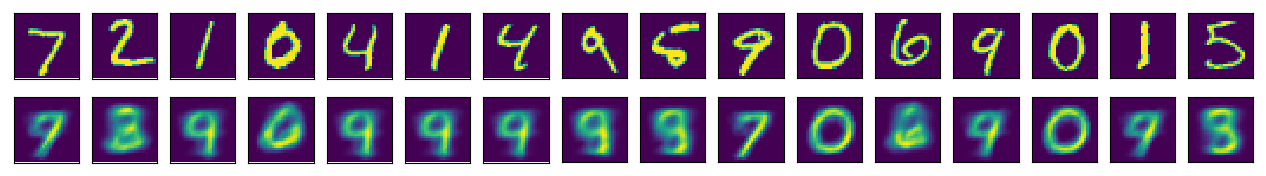

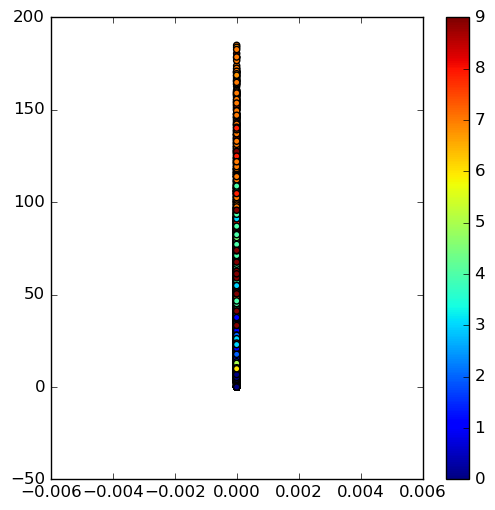

In [242]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=True)
def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
    return BCE

learn = learner_test(crit=flat_bce)
model_plots(learn.model)

#### Learner w/ flat-BCE size average = False; no KLD

epoch      trn_loss   val_loss                                    
    0      2592.764598 2532.484053
    1      2480.420413 2464.72482                                 
    2      2444.895368 2428.478161                                
[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


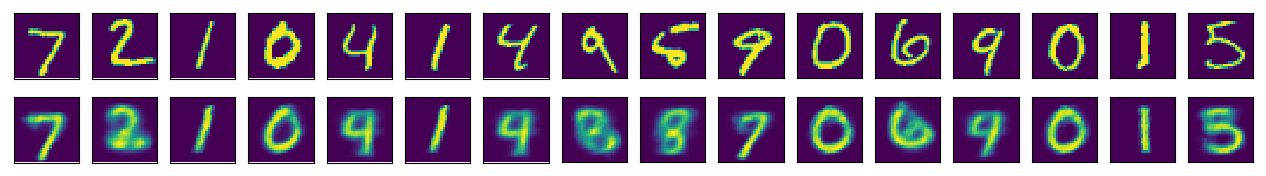

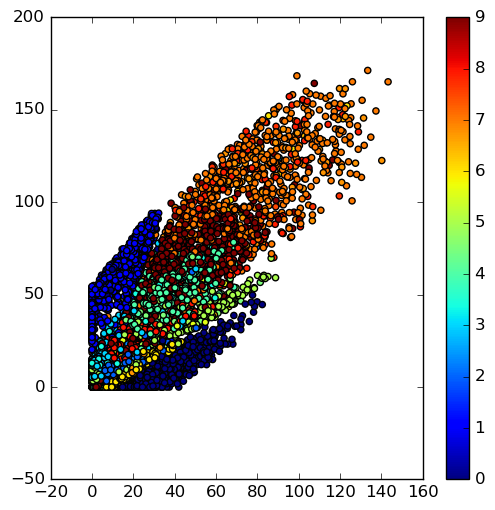

In [243]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=False)

learn = learner_test(crit=flat_bce)
model_plots(learn.model)

#### Learner w/ stock-BCE loss (size avg = True); no KLD

epoch      trn_loss   val_loss                                 
    0      0.229373   0.227395  
    1      0.223582   0.222307                                 
    2      0.219803   0.219521                                 
[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


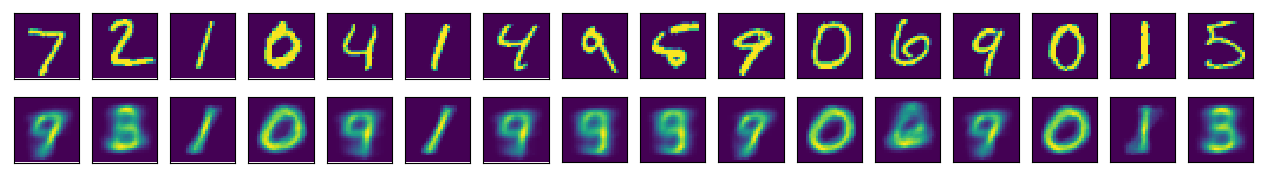

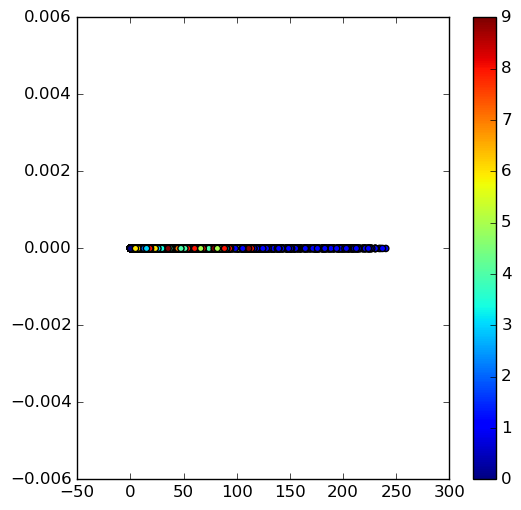

In [244]:
learn = learner_test(crit=F.binary_cross_entropy)
model_plots(learn.model)

#### Learner w/ stock BCE loss + KLD

epoch      trn_loss   val_loss                                 
    0      0.265216   0.263291  
    1      0.261649   0.263141                                 
    2      0.262463   0.262737                                 
[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


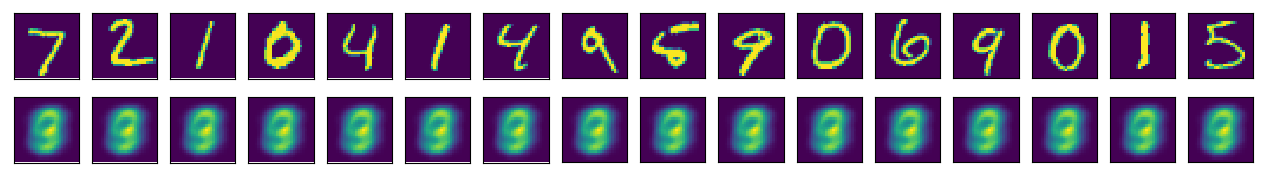

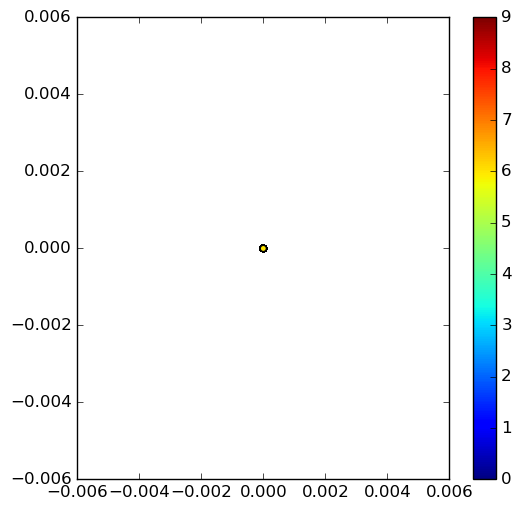

In [245]:
def vae_loss(z, xtra, raw_loss):
#     pdb.set_trace()
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return BCE + KLD

learn = learner_test(crit=F.binary_cross_entropy)
model_plots(learn.model)

#### Learner w/ flat-BCE (size avg=True) + KLD

epoch      trn_loss   val_loss                                 
    0      0.26505    0.263623  
    1      0.262865   0.263003                                 
    2      0.262475   0.262923                                 
[torch.Size([16, 1, 28, 28]), torch.Size([16, 2]), torch.Size([16, 2]), torch.Size([16, 2])]


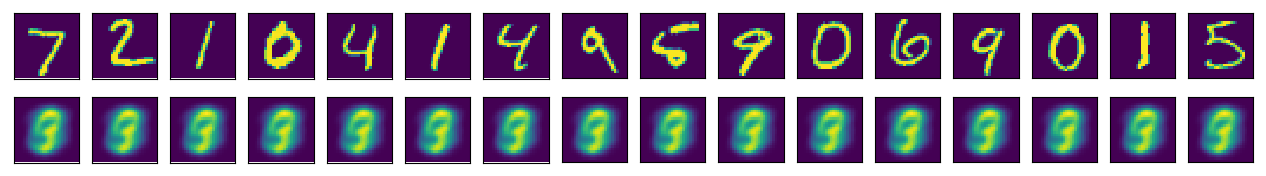

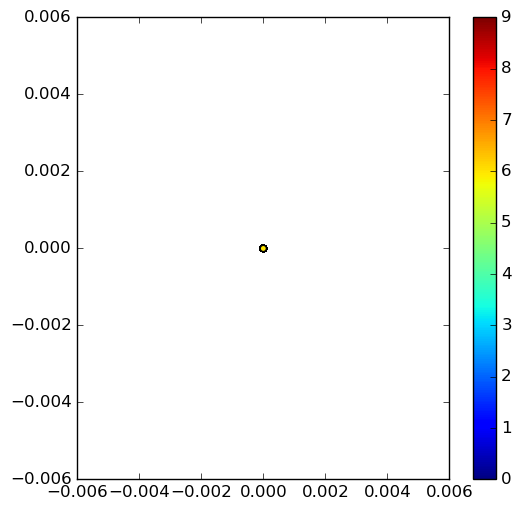

In [246]:
def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=True)
learn = learner_test(crit=flat_bce)
model_plots(learn.model)

In [247]:
def vae_loss(z, xtra, raw_loss):
    pdb.set_trace()
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
    return BCE + KLD

def flat_bce(preds, targs):
    return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
                                  targs.view(targs.size(0),-1), size_average=True)
learn = learner_test(crit=flat_bce)
model_plots(learn.model)

  0%|          | 0/3750 [00:00<?, ?it/s]> <ipython-input-247-593e0d67ea8f>(3)vae_loss()
-> μ, logv, *_ = xtra
(Pdb) raw_loss
tensor(0.7053)
(Pdb) n
> <ipython-input-247-593e0d67ea8f>(4)vae_loss()
-> BCE = raw_loss
(Pdb) n
> <ipython-input-247-593e0d67ea8f>(5)vae_loss()
-> KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
(Pdb) n
> <ipython-input-247-593e0d67ea8f>(6)vae_loss()
-> return BCE + KLD
(Pdb) KLD
tensor(0.1374)
(Pdb) BCE
tensor(0.7053)
(Pdb) q


BdbQuit: 

#### Learner w/ flat-BCE (size avg=False) + KLD

In [ ]:
# class saveBCEKLD(Callback):
#     def __init__(self):
#         self.bce = []
#         self.kld = []
#     def on_batch_end(self)

In [ ]:
2

In [ ]:
# def flat_bce(preds, targs):
#     return F.binary_cross_entropy(preds.view(preds.size(0),-1), 
#                                   targs.view(targs.size(0),-1), size_average=True)

def vae_loss(z, xtra, raw_loss):
    μ, logv, *_ = xtra
    BCE = raw_loss
    KLD = -0.5*torch.sum(1 + logv - μ.pow(2) - logv.exp())
#     if np.isclose(KLD.detach(), 0.0): pdb.set_trace()
#     print(f'\nBCE: {BCE.data}, KLD: {KLD.data}')
    return BCE + KLD


learn = learner_test(crit=F.binary_cross_entropy)
model_plots(learn.model)

#### Pytorch model BCE loss only

#### Pytorch model KL loss only

#### Pytorch model with KL + BCE loss